In [ ]:
!pip install scikit-fuzzy

import warnings
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.7 MB/s eta 0:00:00


# Metody inteligencji obliczeniowej - Sprawozdanie 5

# Zbiory rozmyte. Wnioskowanie rozmyte.

### Yuliya Zviarko, 16.04.25

# Wprowadzenie
W ciągu studiów mieliśmy styczność jedynie z **logiką tradycyjną**, w której każdy element przyjmował wartość logiczną 0 lub 1 (ewentualnie True lub False). Jednak na kolejnych zajęciach dowiedzieliśmy się o istnieniu **logiki rozmytej**, której zadaniem jest definiowanie funkcji przynależności przyjmującej rzeczywiste wartości z zakresu od 0 do 1.

Tego typu logikę stosowaliśmy podczas realizacji zadań laboratoryjnych, w których pracowaliśmy na danych takich jak temperatura czy wilgotność – gdzie trudno jednoznacznie określić, czy jest gorąco, czy zimno, albo bardzo wilgotno, czy sucho. Właśnie w takich przypadkach z pomocą przychodzi wnioskowanie rozmyte, którego zastosowanie przedstawiono w poniższych zadaniach.

# Zadanie 1

Zadanie pierwsze polegało na zaprojektowaniu rozmytego systemu automatycznego podlewania grządki. Wiemy, że grządka ma wymiary **3$m^2$**, a limit podlewania wynosi **25l/dziennie**, gdy tymczasem zalecana ilość wody dla „zwyczajnych” warunków i takich wymiarów to tylko **10l/dziennie**.

System jest sterowany elektronicznie i jest do niego podłączony higrometr (mierzący wilgotność względną w zakresie od 0% do 100%) oraz termometr. Temperatury są mierzone wyłącznie za dnia i mieszczą się w zakresie od 15°C do 35°C. Projektując układ rozmytego sterowania, należało zdefiniować reguły wnioskowania na podstawie następującej tabeli:

|                 | Sucho             | Przeciętnie                | Mokro      |
|-----------------|----------------------|----------------------|------------------|
| **Chłodno**     | Podlewaj średnio        | Podlewaj średnio     | Podlewaj mało    |
| **Ciepło**      | Podlewaj dużo        | Podlewaj średnio        | Podlewaj mało |
| **Gorąco**      | Podlewaj dużo | Podlewaj dużo        | Podlewaj średnio    |


Należało samodzielnie zaproponować rozmyte funkcje przynależności i przedstawić je na wykresach. Następnie trzeba było przygotować heatmapę przedstawiającą wynikową funkcję ilości wody używanej dziennie, w zależności od wilgotności i temperatury zakodowanej w mechanizmie sterowania.

Przed rozpoczęciem zadania chciałam zaznaczyć, że dla wilgotności przyjęłam założenie, iż średnia wartość to 77% dla miasta Kraków (na podstawie danych z https://ruj.uj.edu.pl/server/api/core/bitstreams/8f6e1bce-6c57-48b0-8930-ff76500c120b/content)


---



Na początku tworzymy sobie zmienne wejściowe:
- Temperatura w przedziale od 15 do 35°C,
- Wilgotność od 0 do 100%.
Są to nasze warunki wejściowe — dlatego oznaczamy je jako **Antecedent**.


Zmienna **used_water**, czyli ilość zużytej wody dziennie (0–25 litrów), jest wynikiem działania naszego systemu rozmytego, więc oznaczamy ją jako **Consequent**.

Następnie definiujemy funkcje przynależności (membership functions) dla trzech zmiennych:
- dla temperatury: cold, normal, hot,
- dla wilgotności: dry, normal, wet — zgodnie z rzeczywistymi warunkami pogodowymi w Krakowie,
- oraz dla zużycia wody: little, normal, much.


Ważne było, aby przy definiowaniu granic nie było "dziur" między przedziałami — każda wartość powinna należeć przynajmniej częściowo do jakiejś kategorii. Dzięki temu nasz system będzie mógł sprawnie przyporządkować wejściowe dane do odpowiednich stanów rozmytych i płynnie przechodzić między nimi w zależności od sytuacji.

We wszystkich przypadkach stosowałam funkcję trapezową **trapmf**, aby lepiej oddać rozmyte przejścia pomiędzy kategoriami, co lepiej oddaje rzeczywiste zmiany warunków bez ostrych granic.

In [ ]:
temperature = ctrl.Antecedent(np.arange(15, 35.1, 0.1), 'temperature')
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')

used_water  = ctrl.Consequent(np.arange(0, 25.1, 0.1),'used_water')

temperature['cold'] = fuzz.trapmf(temperature.universe, [15, 15, 15, 20])
temperature['normal'] = fuzz.trapmf(temperature.universe, [15, 20, 25, 30])
temperature['hot'] = fuzz.trapmf(temperature.universe, [25, 30, 35, 35])

humidity['dry'] = fuzz.trapmf(humidity.universe, [0, 0, 65, 75])
humidity['normal'] = fuzz.trapmf(humidity.universe, [70, 75, 85, 90])
humidity['wet'] = fuzz.trapmf(humidity.universe, [87, 90, 100, 100])

used_water['little'] = fuzz.trapmf(used_water.universe, [0, 0, 5, 10])
used_water['normal'] = fuzz.trapmf(used_water.universe, [5, 10, 15, 20])
used_water['much'] = fuzz.trapmf(used_water.universe, [15, 20, 25, 25])

Stosując funkcję wbudowaną **.view()** dla każdej ze zmiennych (temperature, humidity, used_water), w prosty sposób udało się wygenerować wykresy przedstawiające funkcje przynależności dla poszczególnych kategorii. Dzięki temu można było wizualnie sprawdzić, czy zdefiniowane rozmyte zbiory odpowiadają przyjętym założeniom. Dodatkowo, taka wizualizacja znacznie ułatwiła pracę nad dopasowywaniem modelu i jego ewentualnymi poprawkami.

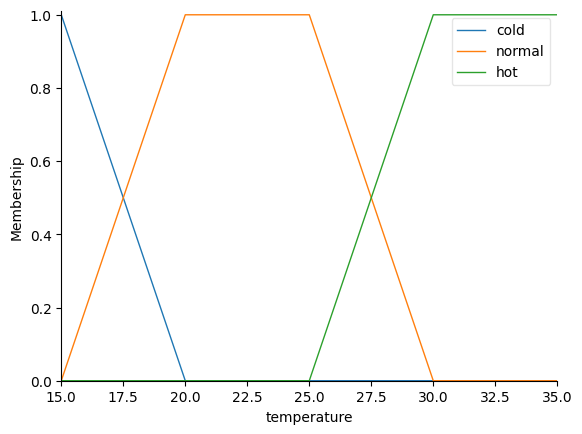

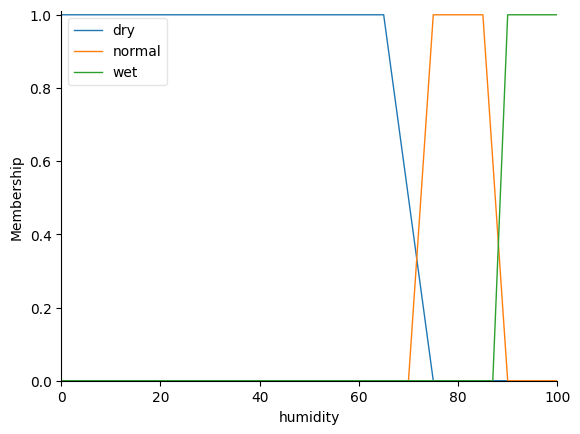

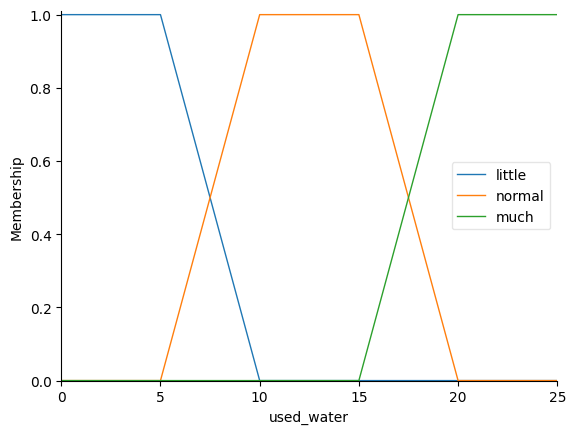

In [ ]:
temperature.view()
humidity.view()
used_water.view()

Z kolei przy użyciu **.Rule()** rozpisałam reguły rozmyte w celu ustalenia ilości wody potrzebnej do podlewania grządki w zależności od temperatury i wilgotności. Mając w treści zadania tabelkę z tymi regułami, co bardzo ułatwiło wykonanie zadania, udało się szybko i sprawnie zdefiniować w kodzie dziewięć reguł, z których każda łączy konkretną kombinację temperatury i wilgotności z określoną ilością wody.

Po zdefiniowaniu wszystkich reguł, stworzyłam system sterowania za pomocą klasy **ControlSystem** oraz symulację tego systemu przy pomocy klasy **ControlSystemSimulation**.

Następnie wprowadziłam do modelu konkretne dane wejściowe: temperaturę (27°C) oraz wilgotność (30%). Po wykonaniu obliczeń za pomocą metody **.compute()**, otrzymałam wynik, który wskazuje, jaka ilość wody jest zalecana do podlewania w danych warunkach. Na podstawie tych danych model proponuje wartość około **20.7 litrów dziennie**.

Zobrazowałam wynik, stosując funkcję **.view(sim=model)**. W ten sposób dobrze widać, jak system reaguje na dane wejściowe i jaka jest proponowana ilość wody do podlewania.

temperatura: 27, wiglotnosc: 30
Model proponuje podlewanie:  20.7


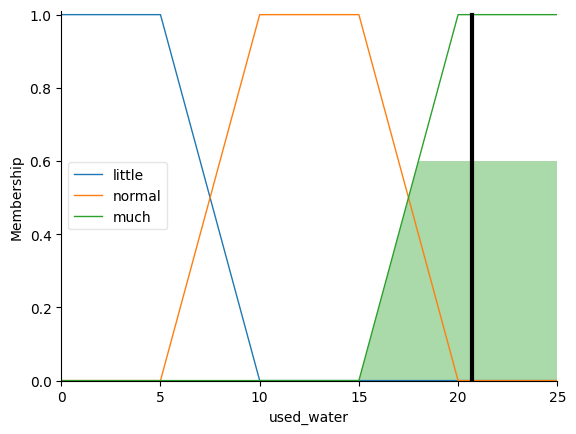

In [ ]:
rule1 = ctrl.Rule(temperature['cold'] & humidity['dry'], used_water['normal'])
rule2 = ctrl.Rule(temperature['cold'] & humidity['normal'], used_water['normal'])
rule3 = ctrl.Rule(temperature['cold'] & humidity['wet'], used_water['little'])

rule4 = ctrl.Rule(temperature['normal'] & humidity['dry'], used_water['much'])
rule5 = ctrl.Rule(temperature['normal'] & humidity['normal'], used_water['normal'])
rule6 = ctrl.Rule(temperature['normal'] & humidity['wet'], used_water['little'])

rule7 = ctrl.Rule(temperature['hot'] & humidity['dry'], used_water['much'])
rule8 = ctrl.Rule(temperature['hot'] & humidity['normal'], used_water['much'])
rule9 = ctrl.Rule(temperature['hot'] & humidity['wet'], used_water['normal'])


control_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
model = ctrl.ControlSystemSimulation(control_system)

model.input['temperature'] = 27
model.input['humidity'] = 30
model.compute()

print('temperatura: 27, wiglotnosc: 30')
print('Model proponuje podlewanie: ', round(model.output['used_water'],1))
used_water.view(sim=model)

Ostatnim krokiem było stworzenie **heatmapy**.

Najpierw, przy użyciu **np.meshgrid()**, wygenerowałam główną siatkę, po której przeprowadzamy obliczenia dla każdej kombinacji temperatury i wilgotności. Zdefiniowane wartości temperatury (od 15°C do 35,5°C) oraz wilgotności (od 0% do 100%) posłużyły do stworzenia tej siatki.

Następnie, dla każdej pary temperatury i wilgotności, wprowadziłam odpowiednie dane wejściowe do modelu, wykonałam obliczenia, a wynik (ilość zużytej wody) zapisałam w macierzy **used_water_results**. W taki sposób, krok po kroku, macierz została wypełniana wartościami zgodnie z wynikami uzyskanymi przez nasz model.


Po obliczeniu wyników dla wszystkich kombinacji temperatury i wilgotności, stworzyłam heatmapę, wykorzystując dane z macierzy **used_water_results**.
Użyłam **seaborn** do wygenerowania wykresu, który wizualizuje, jak zmienia się zużycie wody w zależności od temperatury i wilgotności.
Na wykresie, z odpowiednimi etykietami osi i tytułem, łatwo można zobaczyć, jak te dwie zmienne wpływają na proponowaną ilość wody.

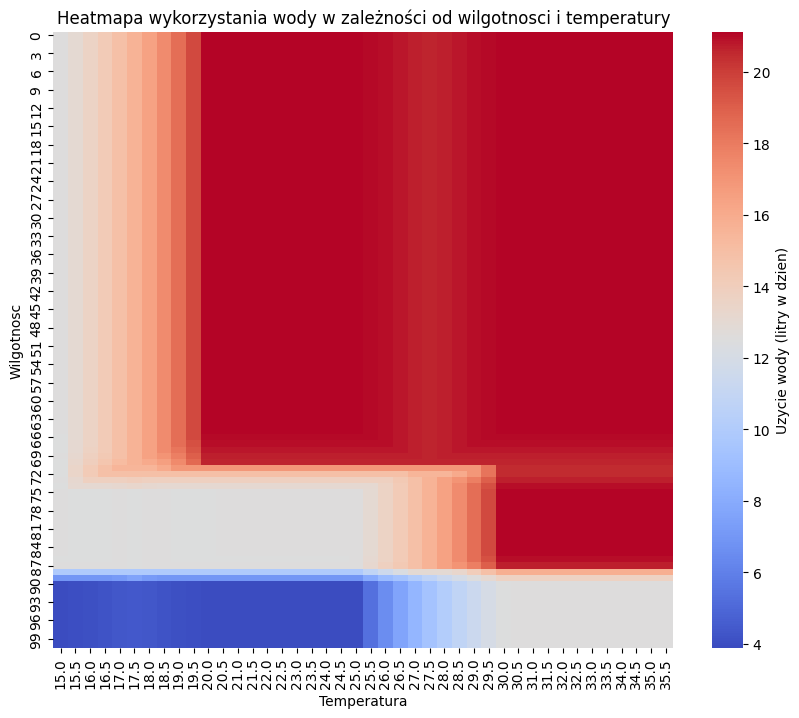

In [ ]:
import numpy as np

temperature_values = np.arange(15, 36, 0.5)
humidity_values = np.arange(0, 101, 1)
temperature_grid, humidity_grid = np.meshgrid(temperature_values, humidity_values)


used_water_results = np.zeros_like(temperature_grid, dtype=float)

for i in range(temperature_grid.shape[0]):
    for j in range(temperature_grid.shape[1]):
        model.input['temperature'] = temperature_grid[i, j]
        model.input['humidity'] = humidity_grid[i, j]
        model.compute()
        used_water_results[i, j] = model.output['used_water']

heatmap_data = pd.DataFrame(used_water_results, index=humidity_values, columns=temperature_values)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Uzycie wody (litry w dzien)'})
plt.title('Heatmapa wykorzystania wody w zależności od wilgotnosci i temperatury')
plt.xlabel('Temperatura')
plt.ylabel('Wilgotnosc')
plt.show()

Aby sprawdzić wiarygodność wykresu, przeprowadziłam kilka testów:
- Temperatura umiarkowana (np. 23°C), wilgotność średnia (np. 75%) – model wskazuje zużycie na poziomie około 12,5 litra, co również jest zgodne z regułą, według której należy podlewać średnio.
- Temperatura niska (np. 15°C,) wilgotność wysoka (np 95%) – zużycie wody wynosi około 4 litry, co zgadza się z regułą mówiącą, że w takich warunkach należy podlewać niewiele.


Przeprowadzając podobne testy dla innych zestawów danych, doszłam do wniosku, że zaproponowany model działa poprawnie w określonych warunkach. Może być z powodzeniem stosowany do prognozowania zużycia wody przy uwzględnieniu typowych warunków pogodowych dla miasta Kraków.

# Zadanie 2
Kolejne zadanie miało następującą treść: Proszę zaproponować rozmyty system wnioskowania dla dowolnego wybranego (ale różnego od poruszanych dotychczas) problemu. Proszę wziąć pod uwagę co najmniej trzy zmienne wejściowe i każdą zmienną podzielić na co najmniej trzy zbiory rozmyte. Proszę stworzyć co najmniej 5 reguł i skomentować wyniki.

Połączyłam przyjemne z pożytecznym, wybierając temat związany z moją pasją – boulderingiem. Załączam nawet zdjęcie z mojego ostatniego treningu :)

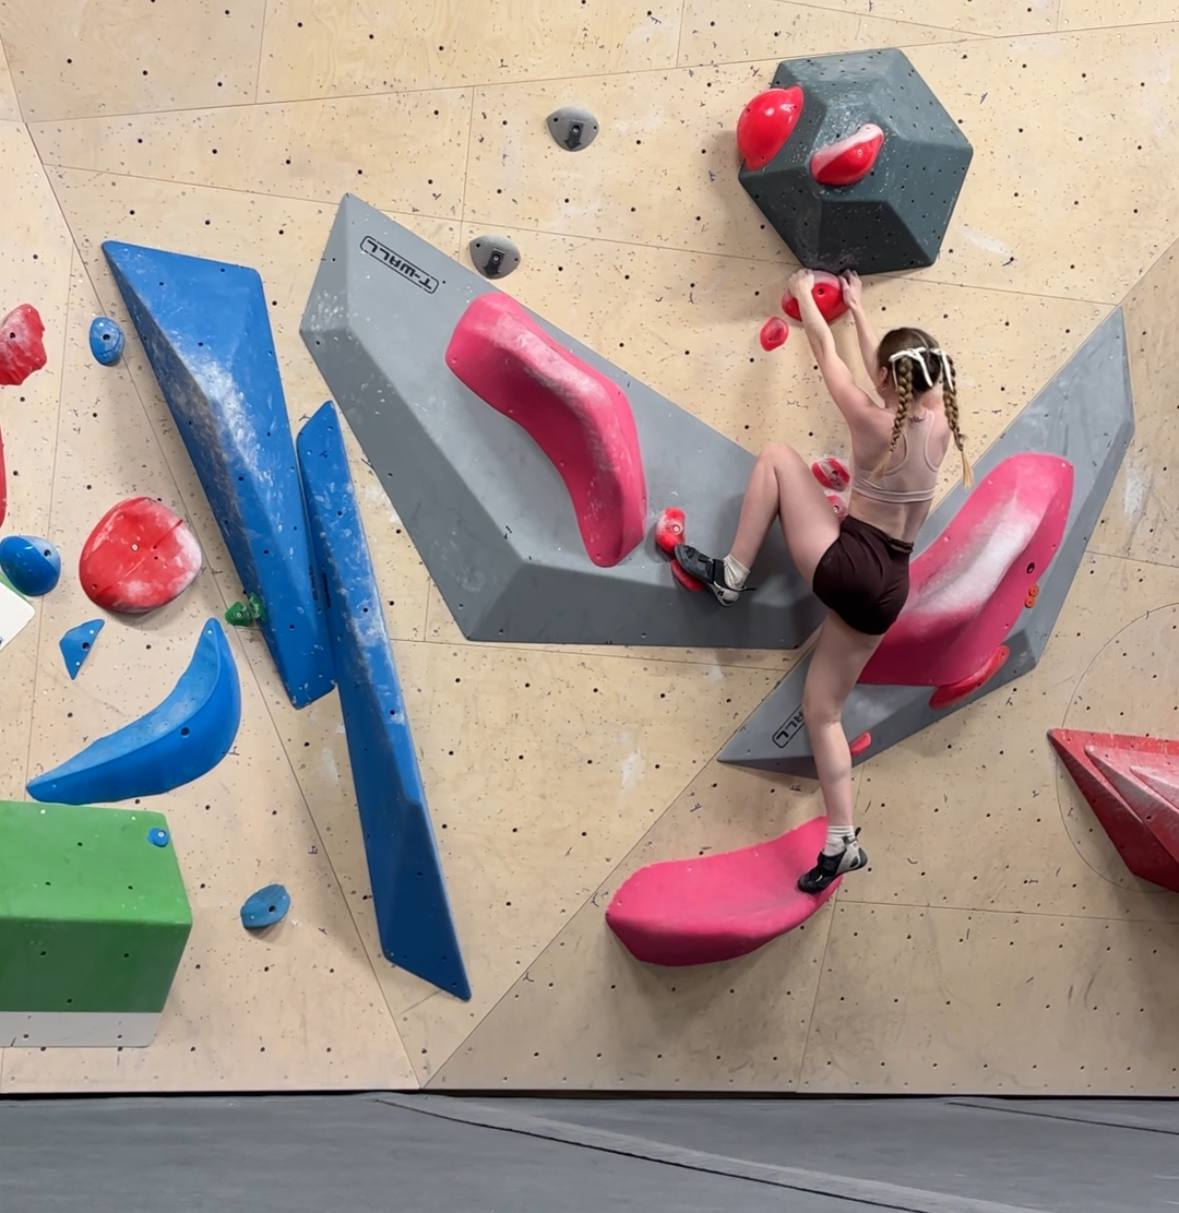

Moją propozycję jest system oceny doboru trudności problemu boulderowego.

Mamy 3 zmienne wejściowe:

1) **Nachylenie ściany**:
- Pochyła (0-30°) - Ściana o małym kącie nachylenia.
- Pionowa (30-60°) - Ściana o średnim kącie nachylenia.
- Przewieszona (60-90°) - Ściana o dużym kącie nachylenia, gdzie kąt jest bliski lub osiąga 90°.

2) **Wielkość chwytów**:
- Duże – Chwyty o dużej powierzchni, łatwe do uchwycenia.
- Średnie – Chwyty o średniej wielkości, wymagające większej precyzji.
- Małe – Chwyty o małej powierzchni, wymagające dużej precyzji i siły palców.

3) **Tarcie powierzchni**:
- Dobre – Powierzchnia chropowata, zapewniająca dobre oparcie dla stóp i dłoni. Ułatwia balans i zwiększa kontrolę.
- Średnie – Umiarkowane tarcie, wymagające większej precyzji w ustawieniu ciała.
- Słabe – Śliska powierzchnia, utrudniająca utrzymanie się na stopniach i chwytach, często wymaga bardzo dokładnej techniki.

Wynikiem działania systemu rozmytego jest poziom trudności.

**Poziom trudności wspinaczki**:

Określenie poziomu trudności stanowi złożony problem ze względu na istnienie wielu różnych metod klasyfikacji – w tym przyporządkowania kolorów, numeracji lub innych systemów oznaczeń. Ponieważ różne kraje mogą stosować odrębne skale oceny, w niniejszej klasyfikacji przyjęłam następujące ujednolicone kryteria:

- I – łatwe – Trudność na poziomie podstawowym, odpowiednie dla początkujących wspinaczy.
- II – dość trudne – Wspinaczka średniej trudności, odpowiednia dla osób, które mają już pewne doświadczenie.
- III – trudne – Wspinaczka wymagająca dużej techniki i siły, odpowiednia dla średnio zaawansowanych wspinaczy.
- IV – bardzo trudne – Wspinaczka na wyższym poziomie trudności, wymagająca znacznych umiejętności i przygotowania fizycznego.
- V – nadzwyczaj trudne – Wspinaczka dla zaawansowanych, wymagająca dużej precyzji i doświadczenia.
- VI – skrajnie trudne – Najwyższy poziom trudności, odpowiedni dla profesjonalnych wspinaczy, którzy muszą posiadać zarówno umiejętności, jak i wytrzymałość.

Ponieważ w zaproponowanym problemie mamy trzy zmienne wejściowe (nachylenie, chwyty, tarcie) oraz szeroką skalę trudności, stworzyłam kompleksowy zestaw reguł. Dzięki temu system lepiej odwzorowuje rzeczywiste warunki wspinaczkowe, uwzględniając nawet nietypowe kombinacje parametrów.



---


A. Poziom podstawowy (I - łatwe)

1. Nachylenie: pochyłe + Chwyty: duże + Tarcie: dobre → I

2. Nachylenie: pochyłe + Chwyty: duże + Tarcie: średnie → I

3. Nachylenie: pochyłe + Chwyty: średnie + Tarcie: dobre → I


---

B. Poziom średniozaawansowany (II - dość trudne)

4. Nachylenie: pionowe + Chwyty: duże + Tarcie: dobre → II

5. Nachylenie: pionowe + Chwyty: średnie + Tarcie: średnie → II

6. Nachylenie: pochyłe + Chwyty: małe + Tarcie: dobre → II



---



C. Poziom zaawansowany (III - trudne)

7. Nachylenie: pionowe + Chwyty: małe + Tarcie: dobre → III

8. Nachylenie: przewieszone + Chwyty: duże + Tarcie: dobre → III

9. Nachylenie: pionowe + Chwyty: średnie + Tarcie: słabe → III



---



D. Poziom ekspercki (IV-VI)

10. Nachylenie: przewieszone + Chwyty: średnie + Tarcie: średnie → IV (bardzo trudne)


11. Nachylenie: pionowe + Chwyty: małe + Tarcie: średnie → IV (bardzo trudne)

12. Nachylenie: przewieszone + Chwyty: duże + Tarcie: średnie → IV (bardzo trudne)

13. Nachylenie: przewieszone + Chwyty: małe + Tarcie: dobre → V (nadzwyczaj trudne)

14. Nachylenie: pionowe + Chwyty: małe + Tarcie: słabe → V (nadzwyczaj trudne)

15. Nachylenie: przewieszone + Chwyty: średnie + Tarcie: słabe → V (nadzwyczaj trudne)

16. Nachylenie: przewieszone + Chwyty: małe + Tarcie: średnie → VI (skrajnie trudne)

17. Nachylenie: przewieszone + Chwyty: średnie + Tarcie: słabe → VI (skrajnie trudne)

18. Nachylenie: przewieszone + Chwyty: małe + Tarcie: słabe → VI (skrajnie trudne)


---




E. Specjalne przypadki

19. Nachylenie: pionowe + Chwyty: duże + Tarcie: słabe → III

20. Nachylenie: pochyłe + Chwyty: małe + Tarcie: słabe → IV



Implementacja systemu rozmytego zasadniczo opiera się na tej samej metodologii co w przypadku zadania pierwszego. Główna różnica polega na zwiększeniu liczby parametrów wejściowych z dwóch do trzech, co wymagało opracowania szerszego spektrum reguł decyzyjnych, które uwzględniają wszystkie możliwe kombinacje tych trzech czynników.

 Zastosowałam sześciostopniową gradację trudności, od poziomu podstawowego aż po ekstremalnie wymagający, co lepiej oddaje rzeczywiste warunki spotykane podczas wspinaczki.

Rozbudowana struktura reguł wnioskowania uwzględnia nie tylko typowe kombinacje parametrów, ale także specjalne przypadki, które mogą wystąpić w praktyce. Takim podejściem chciałam zapewnić bardziej precyzyjne wyniki oceny trudności.


In [23]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# zmienne wejściowe
incline = ctrl.Antecedent(np.arange(0, 91, 1), 'nachylenie')
holds = ctrl.Antecedent(np.arange(0, 11, 1), 'chwyty')
friction = ctrl.Antecedent(np.arange(0, 11, 1), 'tarcie')

# zmienna wyjściowa
difficulty = ctrl.Consequent(np.arange(0, 7, 1), 'trudnosc')  # Skala I-VI

# funkcje przynależności - nachylenie
incline['pochyle'] = fuzz.trimf(incline.universe, [0, 15, 30])
incline['pionowe'] = fuzz.trimf(incline.universe, [30, 45, 60])
incline['przewieszone'] = fuzz.trimf(incline.universe, [60, 75, 90])

# funkcje przynależności - chwyty
holds['male'] = fuzz.trimf(holds.universe, [0, 2.5, 5])
holds['srednie'] = fuzz.trimf(holds.universe, [3, 5, 7])
holds['duze'] = fuzz.trimf(holds.universe, [5, 7.5, 10])

# funkcje przynależności - tarcie
friction['slabe'] = fuzz.trimf(friction.universe, [0, 2.5, 5])
friction['srednie'] = fuzz.trimf(friction.universe, [3, 5, 7])
friction['dobre'] = fuzz.trimf(friction.universe, [5, 7.5, 10])

# funkcje przynależności - trudność (6 poziomów)
difficulty['I'] = fuzz.trimf(difficulty.universe, [0, 1, 2])
difficulty['II'] = fuzz.trimf(difficulty.universe, [1, 2, 3])
difficulty['III'] = fuzz.trimf(difficulty.universe, [2, 3, 4])
difficulty['IV'] = fuzz.trimf(difficulty.universe, [3, 4, 5])
difficulty['V'] = fuzz.trimf(difficulty.universe, [4, 5, 6])
difficulty['VI'] = fuzz.trimf(difficulty.universe, [5, 6, 6])

# reguly
rules = [
    # Poziom I (łatwe)
    ctrl.Rule(incline['pochyle'] & holds['duze'] & friction['dobre'], difficulty['I']),
    ctrl.Rule(incline['pochyle'] & holds['duze'] & friction['srednie'], difficulty['I']),
    ctrl.Rule(incline['pochyle'] & holds['srednie'] & friction['dobre'], difficulty['I']),

    # Poziom II (dość trudne)
    ctrl.Rule(incline['pionowe'] & holds['duze'] & friction['dobre'], difficulty['II']),
    ctrl.Rule(incline['pionowe'] & holds['srednie'] & friction['srednie'], difficulty['II']),
    ctrl.Rule(incline['pochyle'] & holds['male'] & friction['dobre'], difficulty['II']),

    # Poziom III (trudne)
    ctrl.Rule(incline['pionowe'] & holds['male'] & friction['dobre'], difficulty['III']),
    ctrl.Rule(incline['przewieszone'] & holds['duze'] & friction['dobre'], difficulty['III']),
    ctrl.Rule(incline['pionowe'] & holds['srednie'] & friction['slabe'], difficulty['III']),

    # Poziom IV (bardzo trudne)
    ctrl.Rule(incline['przewieszone'] & holds['srednie'] & friction['srednie'], difficulty['IV']),
    ctrl.Rule(incline['pionowe'] & holds['male'] & friction['srednie'], difficulty['IV']),
    ctrl.Rule(incline['przewieszone'] & holds['duze'] & friction['srednie'], difficulty['IV']),

    # Poziom V (nadzwyczaj trudne)
    ctrl.Rule(incline['przewieszone'] & holds['male'] & friction['dobre'], difficulty['V']),
    ctrl.Rule(incline['pionowe'] & holds['male'] & friction['slabe'], difficulty['V']),
    ctrl.Rule(incline['przewieszone'] & holds['srednie'] & friction['slabe'], difficulty['V']),

    # Poziom VI (skrajnie trudne)
    ctrl.Rule(incline['przewieszone'] & holds['male'] & friction['srednie'], difficulty['VI']),
    ctrl.Rule(incline['przewieszone'] & holds['srednie'] & friction['slabe'], difficulty['VI']),
    ctrl.Rule(incline['przewieszone'] & holds['male'] & friction['slabe'], difficulty['VI']),

    # Specjalne przypadki
    ctrl.Rule(incline['pionowe'] & holds['duze'] & friction['slabe'], difficulty['III']),
    ctrl.Rule(incline['pochyle'] & holds['male'] & friction['slabe'], difficulty['IV'])
]

Po zdefiniowaniu wszystkich reguł wnioskowania stworzyłam system sterowania, który łączy wszystkie elementy w całość - obiekt kontrolera (ControlSystem), przekazując mu przygotowaną listę reguł, a następnie przygotowujemy symulator (ControlSystemSimulation), który umożliwi przeprowadzanie obliczeń dla konkretnych wartości wejściowych.

In [24]:
climbing_ctrl = ctrl.ControlSystem(rules)
climbing_sim = ctrl.ControlSystemSimulation(climbing_ctrl)

Na koniec stworzyłam funkcję pomocniczą do weryfikacji działania systemu. Przyjmuje ona trzy parametry wejściowe: wartość nachylenia, rozmiar chwytów i poziom tarcia. Następnie przeprowadza obliczenia i prezentuje przejrzyste podsumowanie wyników.



--- testy ---
Nachylenie: 20°, Chwyty: 8, Tarcie: 8
Ocena trudności: I (łatwe) (wartość: 1.0)


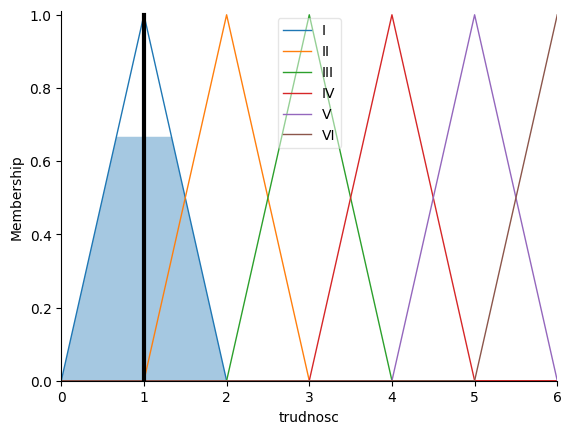

Nachylenie: 45°, Chwyty: 5, Tarcie: 6
Ocena trudności: II (dość trudne) (wartość: 2.0)


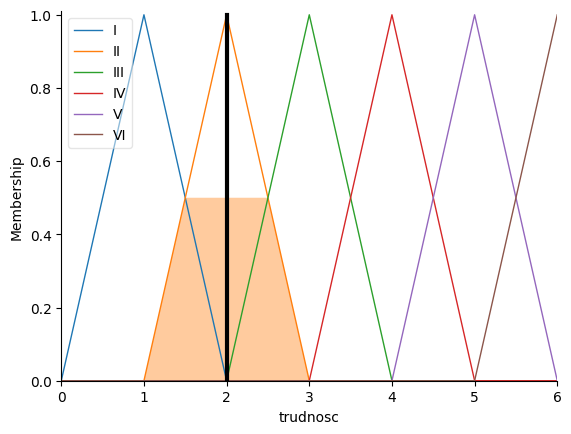

Nachylenie: 70°, Chwyty: 3, Tarcie: 4
Ocena trudności: VI (skrajnie trudne) (wartość: 5.61)


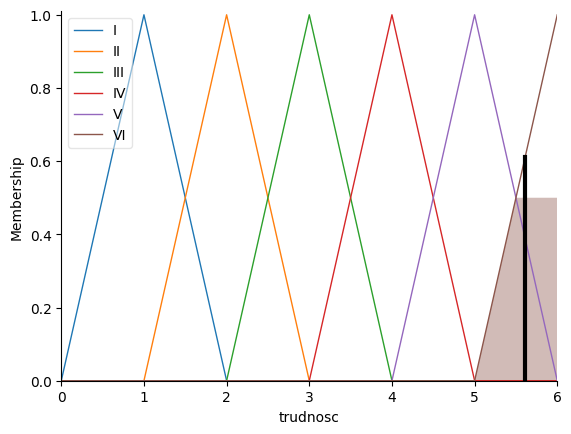

In [28]:
def test_case(incline_val, holds_val, friction_val):
    climbing_sim.input['nachylenie'] = incline_val
    climbing_sim.input['chwyty'] = holds_val
    climbing_sim.input['tarcie'] = friction_val

    try:
        climbing_sim.compute()
        difficulty_level = round(climbing_sim.output['trudnosc'], 2)

        if difficulty_level <= 1: level = "I (łatwe)"
        elif difficulty_level <= 2: level = "II (dość trudne)"
        elif difficulty_level <= 3: level = "III (trudne)"
        elif difficulty_level <= 4: level = "IV (bardzo trudne)"
        elif difficulty_level <= 5: level = "V (nadzwyczaj trudne)"
        else: level = "VI (skrajnie trudne)"

        print(f"Nachylenie: {incline_val}°, Chwyty: {holds_val}, Tarcie: {friction_val}")
        print(f"Ocena trudności: {level} (wartość: {difficulty_level})")

        difficulty.view(sim=climbing_sim)
        plt.show()

    except:
        print("Nie można obliczyć trudności dla podanych parametrów")

print("\n--- testy ---")
test_case(20, 8, 8)  # Pochyłe, duże chwyty, dobre tarcie
test_case(45, 5, 6)  # Pionowe, średnie chwyty, średnie tarcie
test_case(70, 3, 4)  # Przewieszone, małe chwyty, słabe tarcie

Po przeprowadzonych testach widać, że wyniki zgadzają się z proponowaną listą reguł. Jako osoba z doświadczeniem równiez mogę potwierdzić wiarygodność tych rezultatów :D.
Choć ocena trudności bywa subiektywna, w logice rozmytej udało się uzyskać satysfakcjonujące wyniki, które dobrze pokazują rzeczywiste warunki wspinaczkowe.